# Анализ поведения пользователей и эффективности каналов привлечения сервиса по доставке продуктов на дом

# Описание задачи
Проанализировать поведение пользователей и оценить эффективность каналов их привлечения \
в компании-сервисе по доставке продуктов на дом на основе данных за период с 1 января по 31 марта 2020. \
Сервис доступен как в приложении на iOS, так и на Android. 

## Формализованные задачи
1) Построить график с динамикой событий по всем дням.
2) Построить график с динамикой открытий приложений для групп «Установили в тот же день» и «Остальные»
3) Построить график динамики установок приложения в зависимости от канала привлечения пользователя
4) Определить этапы воронки, на которых отваливается большая часть клиентов (для зарегистрированных и для незарегистрированных пользователей)
5) Определить лучший и худший канал по конверсии в первую покупку
6) Рассчитать ROMI для всех каналов привлечения пользователей
7) Провести когортный анализ по неделе первого посещения и по неделе регистрации
8) Рассчитать медианный чек для когорт по неделе первой покупки

In [62]:
# Создадим датафрей на основе данных и ознакомимся с содержимым
import pandas as pd
df = pd.read_csv('SF_case_data.csv')
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   event         object 
 2   purchase_sum  float64
 3   os_name       object 
 4   device_id     int64  
 5   gender        object 
 6   city          object 
 7   utm_source    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 167.7+ MB


In [64]:
# Преобразуем столбец с датой в нужный формат
df.date = pd.to_datetime(df.date, dayfirst=True)

In [65]:
# Отсортируем таблицу по номеру устройства и дате, а также вынесем для удобства вперёд столбец с идентификатором устройства
df = df.sort_values(['device_id','date']).reset_index().drop('index', axis=1)
df = df[['device_id'] + [x for x in df.columns if x != 'device_id']]
df.head()

,device_id,date,event,purchase_sum,os_name,gender,city,utm_source
0,4013,2020-01-15,app_start,NaN,android,female,Saint-Petersburg,vk_ads
1,4013,2020-01-15,choose_item,NaN,android,female,Saint-Petersburg,vk_ads
2,4013,2020-01-15,search,NaN,android,female,Saint-Petersburg,vk_ads
3,4013,2020-01-15,tap_basket,NaN,android,female,Saint-Petersburg,vk_ads
4,4013,2020-01-15,app_install,NaN,android,female,Saint-Petersburg,vk_ads


## 1) График с динамикой по всем событиям по дням

In [66]:
events_grouped = df.groupby('date')['event'].count()
events_grouped = events_grouped.reset_index()

In [67]:
import plotly
import plotly.express as px

events_grouped
fig = px.line(
    data_frame=events_grouped,
    x='date',
    y='event',
    height=500,
    width=1000,
    title='Динамика событий по дням' #заголовок
)
fig.show()



В целом мы наблюдаем тенденцию к постепенному снижению активности пользователей.

## 2) График с динамикой открытий приложений для групп 
## «Установили в тот же день» и «Остальные»

In [68]:
# Внесём в таблицу данные о дне установки приложения для каждого пользователя
installs = df[df.event == 'app_install'].reset_index()
installs = installs[['date','device_id']]
installdate_dict = dict(zip(installs.device_id, installs.date))
df['install_date'] = df['device_id'].apply(
    lambda x: installdate_dict[x] if x in installdate_dict else None
    )

In [69]:
# Создадим столбец, делящий событий на те, которые произошли в день установки и остальные
import numpy as np
df['install_group'] = np.where(df.date==df.install_date, 'same_day_install', 'other')

In [70]:
# Построим сводную таблицу с данными открытий приложений в день установки приложения и в другие дни
app_start_statistic = df[df.event=='app_start'].pivot_table(
    index='date',
    columns='install_group',
    values='event',
    aggfunc='count'
).reset_index()

In [140]:
# Добавим колонку с количеством всех открытий приложения и доли открытий приложения пользователями группы "остальные"
app_start_statistic['total'] = (app_start_statistic.other 
                                + app_start_statistic.same_day_install)
app_start_statistic['percent'] = round(
    app_start_statistic.other/app_start_statistic.total * 100)

app_start_statistic.head()

install_group,date,other,same_day_install,total,percent
0,2020-01-01,866,3579,4445,19.0
1,2020-01-02,1957,3144,5101,38.0
2,2020-01-03,2742,2402,5144,53.0
3,2020-01-04,3093,1831,4924,63.0
4,2020-01-05,3936,1671,5607,70.0


In [72]:
# Построим график на основе полученных данных
fig = px.line(
    data_frame=app_start_statistic, #датафрейм
    x='date', #ось абсцисс
    y=['same_day_install','other'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Динамика открытий приложения, установивших его в тот же день, и остальных' #заголовок
)
fig.show()

У обеих групп - тех кто в тот же день установил приложение и остальных - схожая динамика открытий (всплески активности и падения), \
но в целом значительно активнее пользователи, установившие приложение в предыдущие дни.

## 3) График динамики установок приложения 
## в зависимости от канала привлечения пользователя

In [73]:
channels_installs = df[df.event=='app_install'].pivot_table(
    index='date',
    columns='utm_source',
    values='device_id',
    aggfunc='count'
)


In [74]:
fig = px.line(
    data_frame=channels_installs, #датафрейм
    height=500, #высота
    width=1000, #ширина
    title='Динамика установок приложения по каналам привлечения' #заголовок
)
fig.show()

Пики установок приложения и спады приходятся на одни и те же дни для разных групп,\
лидером по количеству установок приложения оказывается группа пользователей, пришедших через Яндекс.\
Это видно и в графике, и при построении целевого запроса по количеству установок:

In [75]:
df[df.event=='app_install'].groupby('utm_source')['event'].count().sort_values(ascending=False)

utm_source
-                32460
yandex-direct    29368
google_ads       26286
vk_ads           23189
instagram_ads    20096
facebook_ads     13916
referal           9282
Name: event, dtype: int64

Если мы посмотрим на колиство первых открытий приложения, лидером снова окажется Яндекс:

In [121]:
first_app_start = (df[df.event=='app_start']
                   .sort_values('date')
                   .drop_duplicates('device_id'))
first_app_start = (first_app_start
                   .groupby('utm_source')['event']
                   .count().sort_values(ascending=False))
first_app_start

utm_source
-                41456
yandex-direct    34441
google_ads       31437
vk_ads           27905
instagram_ads    24818
facebook_ads     18844
referal          11983
Name: event, dtype: int64

## 4) Этапы воронки, на которых отваливается большая часть клиентов 
### (для зарегистрированных и для незарегистрированных пользователей)

In [122]:
# Определим дату регистрации каждого пользователя и внесём данные в отдельный столбец
registration_dates = (df[df.event=='register'][['device_id','date']]
                      .reset_index().drop('index',axis=1))
registration_dates = dict(zip(registration_dates.device_id,registration_dates.date))
df['registration_date'] = df.device_id.apply(
    lambda x: registration_dates[x] if x in registration_dates else None
    )

In [78]:
# Создадим отдельную колонку, отражающую наличие регистрации на момент события: 1 - зарегистрирован, 0 - не зарегистрирован
df['registered'] = np.where(df.registration_date < df.date, 1, 0)

In [79]:
# Создадим датафреймы для зарегистрированных и незарегистрированных пользователей:
df_reg = df[df.registered == 1]
df_not_reg = df[df.registered == 0]

In [80]:
# Создадим таблицы для обеих групп, в которых оставим для каждого пользователя по одному событию для каждого шага воронки:
df_reg = df_reg.drop_duplicates(subset=['device_id','event'])
df_not_reg = df_not_reg.drop_duplicates(subset=['device_id','event'])


In [123]:
# Подсчитаем количество каждого события среди зарегистрированных пользователей
events_cnt_reg = (df_reg.groupby('event')['device_id']
                  .count().reset_index().rename(columns={'device_id':'users'}))
events_cnt_reg = events_cnt_reg.transpose()
events_cnt_reg.columns = ['app_start','choose_item','purchase','search','tap_basket']
events_cnt_reg.drop(index='event', inplace=True)
events_cnt_reg = events_cnt_reg.astype(int)
events_cnt_reg

,app_start,choose_item,purchase,search,tap_basket
users,40991,37926,24880,40482,34517


Сформируем таблицу с данными по конверсии для каждого шага:

In [141]:
funnel_reg = events_cnt_reg[['app_start','search',
                             'choose_item','tap_basket','purchase']]

In [142]:
funnel_reg = events_cnt_reg[['app_start','search','choose_item',
                             'tap_basket','purchase']].copy()
funnel_reg['step_1'] = round(funnel_reg.search/funnel_reg.app_start * 100, 2)
funnel_reg['step_2'] = round(funnel_reg.choose_item/funnel_reg.search * 100, 2)
funnel_reg['step_3'] = round(funnel_reg.tap_basket/funnel_reg.choose_item * 100, 2)
funnel_reg['step_4'] = round(funnel_reg.purchase/funnel_reg.tap_basket * 100, 2)

### **Зарегистрированные пользователи**:

In [84]:
funnel_reg

,app_start,search,choose_item,tap_basket,purchase,step_1,step_2,step_3,step_4
users,40991,40482,37926,34517,24880,98.76,93.69,91.01,72.08


Мы видим, что конверсия на этапах поиска, выбора товара и корзины выше 90 %, \
однако **на этапе покупки** конверсия достаточно резко **падает до 72%**.

In [143]:
# Посчитаем количество событий в группе незарегистрированных пользователей:

events_cnt_not_reg = (df_not_reg.groupby('event')['device_id']
                      .count().reset_index().rename(columns={'device_id':'users'}))
events_cnt_not_reg = events_cnt_not_reg.transpose()
events_cnt_not_reg.columns = ['app_install','app_start','choose_item',
                              'purchase','register','search','tap_basket']
events_cnt_not_reg.drop(index='event', inplace=True)
events_cnt_not_reg = events_cnt_not_reg.astype(int)
events_cnt_not_reg

,app_install,app_start,choose_item,purchase,register,search,tap_basket
users,154597,190884,155691,67753,78310,184488,125414


Сформируем таблицу с данными по конверсии для каждого шага:

In [144]:
funnel_not_reg = events_cnt_not_reg[['app_start','search','choose_item',
                                     'tap_basket','register','purchase']]
funnel_not_reg['step_1'] = round(
    funnel_not_reg.search/funnel_not_reg.app_start * 100, 2
    )
funnel_not_reg['step_2'] = round(
    funnel_not_reg.choose_item/funnel_not_reg.search * 100, 2
    )
funnel_not_reg['step_3'] = round(
    funnel_not_reg.tap_basket/funnel_not_reg.choose_item * 100, 2
    )
funnel_not_reg['step_4'] = round(
    funnel_not_reg.register/funnel_not_reg.tap_basket * 100, 2
    )
funnel_not_reg['step_5'] = round(
    funnel_not_reg.purchase/funnel_not_reg.register * 100, 2
    )

### **Незарегистрированные пользователи**:

In [87]:
funnel_not_reg

,app_start,search,choose_item,tap_basket,register,purchase,step_1,step_2,step_3,step_4,step_5
users,190884,184488,155691,125414,78310,67753,96.65,84.39,80.55,62.44,86.52


Для незарегистрированных пользователей самым проблематичным оказался **этап регистрации** (конверсия падает до 62 %).\
Следует подумать, как упростить этот шаг, т.к. регистрация является обязательным этапом для совершения покупки.

## 5) Выбор лучшего и худшего канала по конверсии в первую покупку

In [128]:
# Создадим таблицу, содержащую информацию о первом открытии приложения и первой покупке пользователей
conv_data = (df[(df.event == 'purchase') | (df.event == 'app_start')]
             .drop_duplicates(subset=['device_id', 'event'])
             .reset_index(drop=True))
conv_data.head()

,device_id,date,week,event,purchase_sum,os_name,gender,city,utm_source,install_date,install_group,registration_date,registered,first_visit_week,reg_week,first_purch_week
0,4013,2020-01-15,2020-01-13,app_start,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0,2020-01-13,NaT,NaT
1,4014,2020-01-02,2019-12-30,app_start,NaN,android,male,Saint-Petersburg,referal,NaT,other,2020-02-01,0,2019-12-30,2020-01-27,2020-01-27
2,4014,2020-02-01,2020-01-27,purchase,86.0,android,male,Saint-Petersburg,referal,NaT,other,2020-02-01,0,2019-12-30,2020-01-27,2020-01-27
3,4016,2020-01-04,2019-12-30,app_start,NaN,android,female,Saint-Petersburg,yandex-direct,2020-01-04,same_day_install,NaT,0,2019-12-30,NaT,NaT
4,4018,2020-03-27,2020-03-23,app_start,NaN,android,male,Saint-Petersburg,-,NaT,other,NaT,0,2020-03-23,NaT,NaT


In [89]:
# Сформируем таблицу с данными по количеству открытий приложений и покупок по каждому каналу привлечения:
conv_table = conv_data.pivot_table(
    index='utm_source',
    columns='event',
    values='device_id',
    aggfunc='count'
)
conv_table

event,app_start,purchase
utm_source,,
-,41456,14786
facebook_ads,18844,7903
google_ads,31437,10167
instagram_ads,24818,9820
referal,11983,5803
vk_ads,27905,11460
yandex-direct,34441,10936


In [90]:
# Рассчитаем конверсию в первую покупку по каждому каналу в процентах:
conv_table['CR'] = round(conv_table['purchase']/conv_table['app_start'] * 100)
conv_table = conv_table.sort_values(by='CR', ascending=False)
conv_table

event,app_start,purchase,CR
utm_source,,,
referal,11983,5803,48.0
facebook_ads,18844,7903,42.0
vk_ads,27905,11460,41.0
instagram_ads,24818,9820,40.0
-,41456,14786,36.0
google_ads,31437,10167,32.0
yandex-direct,34441,10936,32.0


### Лучшие показатели конверсии в первую покупку у пользователей, пришедших через реферальную программу,
### самые низкие - у пришедших через Яндекс.

Рассчитаем медианный первый чек по каналам привлечения:

In [129]:
median_first_bill = (conv_data[conv_data.event == 'purchase']
                     .groupby('utm_source')['purchase_sum']
                     .median().sort_values(ascending=False))
median_first_bill

utm_source
-                398.5
referal          395.5
instagram_ads    393.5
vk_ads           393.0
yandex-direct    392.5
google_ads       390.5
facebook_ads     389.0
Name: purchase_sum, dtype: float64

Выше остальных медианный первый чек пользователей, пришедших благодаря **реферальной программе**,\
однако заметим, что в целом его величина по разным каналам колеблется незначительно, в пределах 10 рублей (389 - 399 руб).

## 6) Рассчитаем ROMI для всех каналов привлечения пользователей

Данные по затратам на рекламу в Q1:

Яндекс	10 491 707 руб.\
Гугл	10 534 878 руб.\
Фейсбук	8 590 498 руб.\
Инстаграм	8 561626 руб.\
ВК	9 553 531 руб.

Расходы на реферальную программу: если пользователь приведет друга и последний совершит первую покупку, то оба получат по 100 рублей.

Рассчитаем расходы на реферальную программу.\
Для этого определим количество покупок по реферальной программе и умножим получившееся число на 200.

In [130]:
referal_costs = df[
    (df.utm_source == 'referal') & (df.event == 'purchase')
    ]['event'].count() * 200
referal_costs

2567800

Теперь рассчитаем доходы по каждому каналу привлечения пользователей.

In [93]:
channels_data = (df[df.event=='purchase']
                 .groupby('utm_source')['purchase_sum'].sum().reset_index())
channels_data.rename(columns={'purchase_sum':'revenue'}, inplace=True)
channels_data = channels_data.drop(index=0)
channels_data

,utm_source,revenue
1,facebook_ads,12249901.0
2,google_ads,12868276.0
3,instagram_ads,14546969.0
4,referal,8837044.5
5,vk_ads,16389652.5
6,yandex-direct,13915368.0


Добавим в таблицу данные по расходам

In [94]:
channels_costs = [8590498, 10534878, 8561626, referal_costs, 9553531, 10491707]
channels_data['costs'] = channels_costs
channels_data

,utm_source,revenue,costs
1,facebook_ads,12249901.0,8590498
2,google_ads,12868276.0,10534878
3,instagram_ads,14546969.0,8561626
4,referal,8837044.5,2567800
5,vk_ads,16389652.5,9553531
6,yandex-direct,13915368.0,10491707


Рассчитаем ROMI по формуле:
### (доход компании – расход на рекламу)/расход на рекламу × 100%


In [131]:
channels_data['ROMI'] = round(
    (channels_data.revenue - channels_data.costs)/channels_data.costs * 100, 2
    )
channels_data.sort_values(by='ROMI', ascending=False)

,utm_source,revenue,costs,ROMI
4,referal,8837044.5,2567800,244.15
5,vk_ads,16389652.5,9553531,71.56
3,instagram_ads,14546969.0,8561626,69.91
1,facebook_ads,12249901.0,8590498,42.60
6,yandex-direct,13915368.0,10491707,32.63
2,google_ads,12868276.0,10534878,22.15


Хуже всего по метрике ROMI показал себя Гугл, \
лидерами оказываются ВК 
и отдельно выделим реферальную программу - где расходы на рекламу минимальны и ROMI оказывается в разы больше по сравнению с остальными каналами. Однако здесь же стоит отметить, что общие доходы по реферальной программе ниже, чем по всем остальным каналам привлечения пользователей:

In [96]:
channels_data.sort_values(by='revenue', ascending=False)

,utm_source,revenue,costs,ROMI
5,vk_ads,16389652.5,9553531,71.56
3,instagram_ads,14546969.0,8561626,69.91
6,yandex-direct,13915368.0,10491707,32.63
2,google_ads,12868276.0,10534878,22.15
1,facebook_ads,12249901.0,8590498,42.60
4,referal,8837044.5,2567800,244.15


# Когортный анализ
в зависимости от:\
недели первого посещения;\
недели регистрации;\
недели первой покупки.

In [97]:
# Добавим столбец с данными о неделе, в которую произошло событие
df.insert(2, 'week', (df.date - df.date.dt.weekday * np.timedelta64(1, 'D')).dt.date)

In [98]:
df.head()

,device_id,date,week,event,purchase_sum,os_name,gender,city,utm_source,install_date,install_group,registration_date,registered
0,4013,2020-01-15,2020-01-13,app_start,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0
1,4013,2020-01-15,2020-01-13,choose_item,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0
2,4013,2020-01-15,2020-01-13,search,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0
3,4013,2020-01-15,2020-01-13,tap_basket,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0
4,4013,2020-01-15,2020-01-13,app_install,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0


## 7) Таблица когорт по неделе первого посещения


In [132]:
# Определим дату первого посещения каждого пользователя, затем неделю посещения(по первому дню недели) и внесём данные в таблицу:
first_visits = df.groupby('device_id')['date'].min().reset_index()
first_visits = dict(zip(first_visits.device_id, first_visits.date))
df['first_visit_week'] = df.device_id.apply(lambda x: first_visits[x])
df['first_visit_week'] = (
    df['first_visit_week'] - df['first_visit_week'].dt.weekday * np.timedelta64(1, 'D')
    ).dt.date
df.head()

,device_id,date,week,event,purchase_sum,os_name,gender,city,utm_source,install_date,install_group,registration_date,registered,first_visit_week,reg_week,first_purch_week
0,4013,2020-01-15,2020-01-13,app_start,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0,2020-01-13,NaT,NaT
1,4013,2020-01-15,2020-01-13,choose_item,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0,2020-01-13,NaT,NaT
2,4013,2020-01-15,2020-01-13,search,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0,2020-01-13,NaT,NaT
3,4013,2020-01-15,2020-01-13,tap_basket,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0,2020-01-13,NaT,NaT
4,4013,2020-01-15,2020-01-13,app_install,NaN,android,female,Saint-Petersburg,vk_ads,2020-01-15,same_day_install,NaT,0,2020-01-13,NaT,NaT


Построим сводную таблицу по количеству уникальных пользователей по когортам первого посещения в разрезе недель.\
При этом в этой и последующих таблицах мы исключим из анализа данные по последней когорте и последней неделе, так как в данные попали только первые два дня (30 и 31 марта)

In [100]:
unique_users = df.pivot_table(
    index='first_visit_week',
    columns='week',
    values='device_id',
    aggfunc='nunique'
)
unique_users = unique_users[:-1]
unique_users = unique_users[unique_users.columns[:-1]]
unique_users

week,2019-12-30,2020-01-06,2020-01-13,2020-01-20,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23
first_visit_week,,,,,,,,,,,,,
2019-12-30,15705.0,7551.0,6792.0,6338.0,5794.0,5295.0,5452.0,5387.0,4853.0,4983.0,4541.0,4355.0,4498.0
2020-01-06,NaN,31315.0,8228.0,6040.0,4958.0,4222.0,4540.0,4553.0,3507.0,4136.0,3246.0,2944.0,3047.0
2020-01-13,NaN,NaN,30505.0,5068.0,3861.0,3122.0,3610.0,3175.0,2303.0,2894.0,1983.0,1818.0,1923.0
2020-01-20,NaN,NaN,NaN,12319.0,1863.0,1443.0,1706.0,1543.0,1079.0,1388.0,918.0,791.0,873.0
2020-01-27,NaN,NaN,NaN,NaN,13119.0,2037.0,1971.0,1669.0,1227.0,1397.0,1003.0,875.0,909.0
2020-02-03,NaN,NaN,NaN,NaN,NaN,10967.0,1993.0,1599.0,1126.0,1266.0,933.0,804.0,839.0
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,16015.0,2560.0,1487.0,2083.0,1227.0,1019.0,1031.0
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11974.0,1511.0,1606.0,995.0,845.0,884.0
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5172.0,933.0,625.0,499.0,509.0


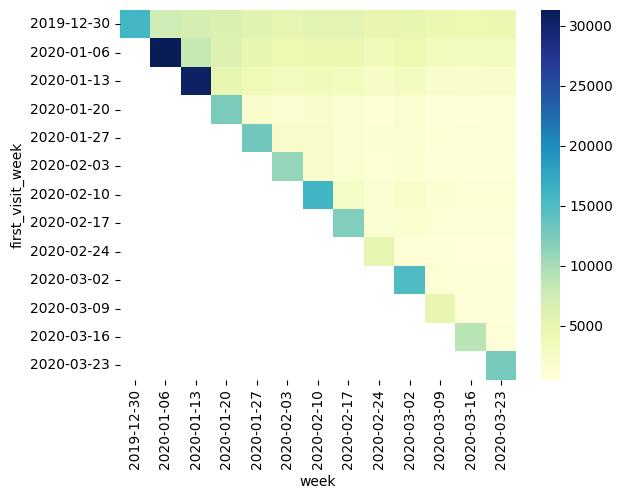

In [101]:
# Построим тепловую карту на основе полученных данных:
import seaborn as sns
sns.heatmap(unique_users, cmap='YlGnBu');

Самой большой по численности оказалась когорта от 06.01.2020

In [133]:
# Создадим таблицу, в которой рассчитаем количество пользователей каждой когорты по неделям относительно первой недели когорты:
unique_users_prc = unique_users

for week in unique_users_prc.columns:
    unique_users_prc.loc[week] = round(
        unique_users_prc.loc[week]/unique_users_prc.loc[week,week] * 100
        )
    
unique_users_prc

week,2019-12-30,2020-01-06,2020-01-13,2020-01-20,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23
first_visit_week,,,,,,,,,,,,,
2019-12-30,100.0,48.0,43.0,40.0,37.0,34.0,35.0,34.0,31.0,32.0,29.0,28.0,29.0
2020-01-06,NaN,100.0,26.0,19.0,16.0,13.0,14.0,15.0,11.0,13.0,10.0,9.0,10.0
2020-01-13,NaN,NaN,100.0,17.0,13.0,10.0,12.0,10.0,8.0,9.0,7.0,6.0,6.0
2020-01-20,NaN,NaN,NaN,100.0,15.0,12.0,14.0,13.0,9.0,11.0,7.0,6.0,7.0
2020-01-27,NaN,NaN,NaN,NaN,100.0,16.0,15.0,13.0,9.0,11.0,8.0,7.0,7.0
2020-02-03,NaN,NaN,NaN,NaN,NaN,100.0,18.0,15.0,10.0,12.0,9.0,7.0,8.0
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,100.0,16.0,9.0,13.0,8.0,6.0,6.0
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,13.0,13.0,8.0,7.0,7.0
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,18.0,12.0,10.0,10.0


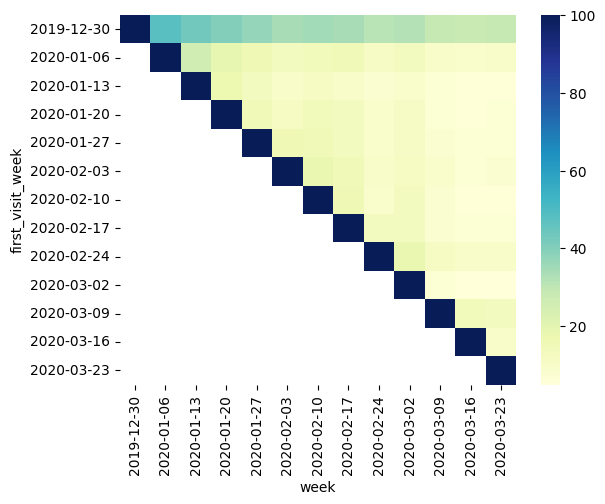

In [103]:
import seaborn as sns
sns.heatmap(unique_users_prc, cmap='YlGnBu');

Мы видим (особенно ярко на данных в процентах), что самую большую активность проявила первая когорта (от 30.12.2019),\
также в целом наблюдаем снижение активности последующих когорт.

Для сравнения построим сводную таблицу по количеству всех событий для каждой когорты по неделям,\
вычислим среднее и построим тепловую карту.

In [104]:
events_statistic = df.pivot_table(
    index='first_visit_week',
    columns='week',
    values='event',
    aggfunc='count'
)
events_statistic = events_statistic[:-1]
events_statistic = events_statistic[events_statistic.columns[:-1]]
events_statistic['mean'] = round(events_statistic.mean(axis=1),0)
events_statistic

week,2019-12-30,2020-01-06,2020-01-13,2020-01-20,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23,mean
first_visit_week,,,,,,,,,,,,,,
2019-12-30,103150.0,80785.0,70974.0,65218.0,60020.0,53350.0,56307.0,57177.0,50383.0,50142.0,47777.0,44268.0,46697.0,60481.0
2020-01-06,NaN,183791.0,60800.0,44555.0,37131.0,31138.0,33285.0,34200.0,26683.0,28609.0,24808.0,21467.0,23741.0,45851.0
2020-01-13,NaN,NaN,175047.0,37592.0,29368.0,23057.0,24666.0,23645.0,17673.0,19551.0,16171.0,13336.0,15307.0,35947.0
2020-01-20,NaN,NaN,NaN,68588.0,14696.0,10715.0,11630.0,10997.0,7992.0,9028.0,7361.0,5892.0,6997.0,15390.0
2020-01-27,NaN,NaN,NaN,NaN,71525.0,15746.0,14067.0,12773.0,9807.0,9849.0,7986.0,6834.0,7723.0,17368.0
2020-02-03,NaN,NaN,NaN,NaN,NaN,60648.0,14756.0,12496.0,8605.0,8908.0,7183.0,6099.0,6954.0,15706.0
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,83766.0,19299.0,11752.0,13204.0,9469.0,7341.0,8467.0,21900.0
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63231.0,11578.0,10902.0,7986.0,6157.0,6788.0,17774.0
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27443.0,6988.0,5009.0,3898.0,4185.0,9505.0


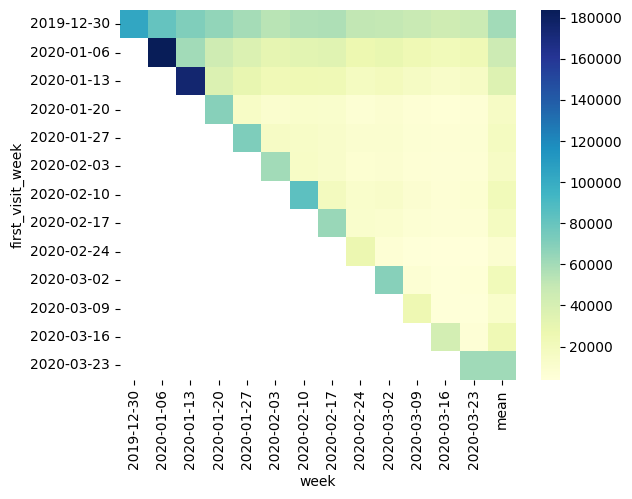

In [105]:
sns.heatmap(events_statistic, cmap='YlGnBu');

Мы видим, что и здесь картина схожая, самой активной когортой оказывается по-прежнему первая, с течением времени активность новых когорт снижается.\
Необходимо уделить внимание разработке рекламных акций/спецпредложений, которые способствовали бы увеличению продаж новым клиентам и их вовлечённости в пользование приложением. 

## 7а) Таблица когорт по неделе регистрации

### Определим, регистрируются ли пользователи в день первого посещения

In [106]:
# Внесём данные о первом визите в таблицу
reg_data = df.copy()
reg_data['first_visit'] = reg_data.device_id.apply(lambda x: first_visits[x])


In [145]:
# Оставим в таблице только пользователей, прошедших регистрацию.
# В отдельном столбце зафиксируем, зарегистрировался ли пользователей в день первого визита.
reg_data = reg_data[reg_data.event == 'register'].reset_index(drop=True)
reg_data['reg_group'] = np.where(
    reg_data.registration_date == reg_data.first_visit, 'same_day', 'other')
reg_data.head()

,device_id,date,week,event,purchase_sum,os_name,gender,city,utm_source,install_date,install_group,registration_date,registered,first_visit_week,first_visit,reg_group
0,4014,2020-02-01,2020-01-27,register,NaN,android,male,Saint-Petersburg,referal,NaT,other,2020-02-01,0,2019-12-30,2020-01-02,other
1,4046,2020-01-04,2019-12-30,register,NaN,android,female,Saint-Petersburg,-,2020-01-04,same_day_install,2020-01-04,0,2019-12-30,2020-01-04,same_day
2,4060,2020-03-07,2020-03-02,register,NaN,ios,male,Saint-Petersburg,yandex-direct,NaT,other,2020-03-07,0,2019-12-30,2020-01-03,other
3,4067,2020-01-31,2020-01-27,register,NaN,android,male,Saint-Petersburg,-,2020-01-31,same_day_install,2020-01-31,0,2020-01-27,2020-01-31,same_day
4,4120,2020-01-07,2020-01-06,register,NaN,android,female,Saint-Petersburg,instagram_ads,2020-01-07,same_day_install,2020-01-07,0,2020-01-06,2020-01-07,same_day


In [108]:
# Посчитаем количество пользователей, зарегистрировавшихся в первый же день и зарегистрировавшихся позже
grouped = reg_data.groupby('reg_group')['device_id'].count()
grouped.name = 'users'
grouped

reg_group
other       25908
same_day    52402
Name: users, dtype: int64

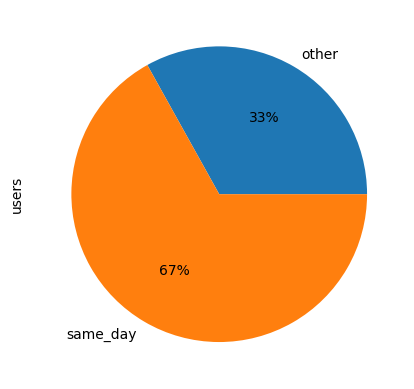

In [109]:
grouped.plot(kind='pie', autopct='%1.0f%%');

Мы видим, что треть пользователей всё же откладывают регистрацию на потом. 


### Выясним, какая когорта по неделе регистрации принесла больше всего денег

Создадим отдельный столбец для недели регистрации и посмотрим размер выручки в зависимости от давности регистрации,\
а также вычислим общую выручку для каждой когорты за весь период:

In [135]:
df['reg_week'] = (
    df.registration_date - df.registration_date.dt.weekday * np.timedelta64(1, 'D')
    ).dt.date

revenue_statistic = df[df.event=='purchase'].pivot_table(
    index='reg_week',
    columns='week',
    values='purchase_sum',
    aggfunc='sum'
)
revenue_statistic = revenue_statistic[:-1]
revenue_statistic = revenue_statistic[revenue_statistic.columns[:-1]]
revenue_statistic['total'] = round(revenue_statistic.sum(axis=1), 0)
revenue_statistic

week,2019-12-30,2020-01-06,2020-01-13,2020-01-20,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23,total
reg_week,,,,,,,,,,,,,,
2019-12-30,3558860.5,1393044.0,1143869.5,1059036.5,888468.0,779835.0,739805.0,734579.5,668602.0,669802.5,582775.5,571773.5,647008.0,13437460.0
2020-01-06,NaN,8781471.0,1887320.0,1487879.5,1348480.5,1017802.0,1043808.5,987917.0,923694.5,766347.5,749529.0,562028.0,680298.5,20236576.0
2020-01-13,NaN,NaN,10322171.5,1663056.0,1229793.5,884512.5,824195.0,723470.0,722463.0,627450.5,579447.5,418022.5,506933.5,18501516.0
2020-01-20,NaN,NaN,NaN,4616685.5,759040.5,527122.5,491580.5,532274.5,455479.0,368272.0,335502.5,285831.5,291269.0,8663058.0
2020-01-27,NaN,NaN,NaN,NaN,4121545.5,613341.0,448318.5,475363.5,402434.5,319081.5,277602.0,237103.5,274454.0,7169244.0
2020-02-03,NaN,NaN,NaN,NaN,NaN,3696992.5,556462.0,488309.0,391046.0,290407.5,308299.0,188107.0,226104.5,6145728.0
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,4345239.5,608469.5,466225.5,352933.0,280031.0,222691.5,269059.5,6544650.0
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3405786.0,519216.0,457163.0,312978.5,245207.5,233919.5,5174270.0
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1884798.0,408627.0,242142.5,139631.0,191542.0,2866740.0


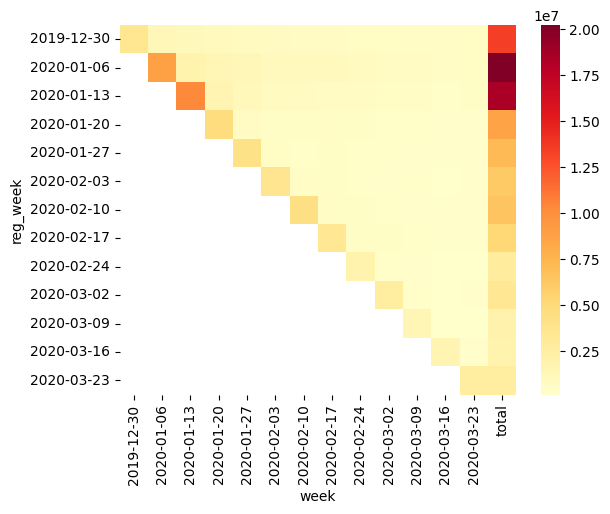

In [111]:
sns.heatmap(revenue_statistic, cmap='YlOrRd');

Мы видим, что когорта второй недели (от 06.01.2020) принесла больше всего выручки, \
и также можем видеть по таблице, что первые три когорты в целом тратят больше денег в неделю по сравнению с теми, \
кто зарегистрировался в последующие недели.

## 8) Таблица когорт по неделе первой покупки и расчёт медианного чека

Добавим в таблицу столбец нелели первой покупки и построим сводную таблицу, отражающую изменение медианного чека по неделям в разных когортах.

In [136]:
first_purchases = (df[df.event=='purchase']
                   .groupby('device_id')['date'].min().reset_index())
first_purchases = dict(zip(first_purchases.device_id, first_purchases.date))
df['first_purch_week'] = df.device_id.apply(
    lambda x: first_purchases[x] if x in first_purchases else None
    )
df['first_purch_week'] = (
    df.first_purch_week - df.first_purch_week.dt.weekday * np.timedelta64(1,'D')
    ).dt.date

In [113]:
median_bill = df[df.event == 'purchase'].pivot_table(
    index='first_purch_week',
    columns='week',
    values='purchase_sum',
    aggfunc='median'
)
median_bill = median_bill[:-1]
median_bill = median_bill[median_bill.columns[:-1]]
median_bill

week,2019-12-30,2020-01-06,2020-01-13,2020-01-20,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23
first_purch_week,,,,,,,,,,,,,
2019-12-30,395.0,390.5,391.5,369.5,392.00,394.75,382.00,375.50,399.50,385.00,402.50,405.50,400.50
2020-01-06,NaN,396.0,396.0,393.5,388.25,402.50,411.00,371.00,420.25,385.50,385.50,377.50,410.00
2020-01-13,NaN,NaN,389.5,392.0,390.00,398.50,391.00,385.25,396.50,400.75,400.50,397.00,411.00
2020-01-20,NaN,NaN,NaN,397.5,404.00,366.50,377.00,384.50,395.50,397.50,406.25,388.00,375.00
2020-01-27,NaN,NaN,NaN,NaN,394.75,389.00,386.50,397.00,389.75,385.50,393.50,392.00,401.00
2020-02-03,NaN,NaN,NaN,NaN,NaN,398.00,410.25,404.25,381.25,419.00,409.00,387.00,357.00
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,397.00,380.25,396.50,403.00,431.25,421.00,382.00
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,392.00,392.00,388.25,391.50,421.50,407.00
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383.00,415.50,415.50,375.50,409.50


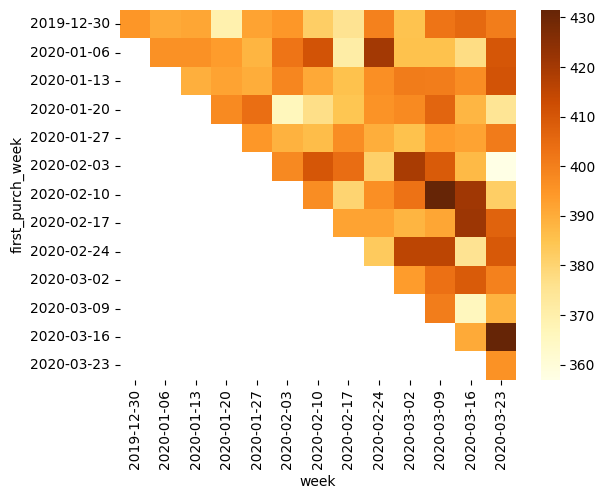

In [114]:
sns.heatmap(median_bill, cmap='YlOrBr');

Величина медианного чека обладает в целом некоторой стабильностью - он колеблется в целом в пределах 380 - 420 руб., \
но самый высокий медианный чек на неделе первой покупки наблюдается у когорты от 09.03.2020 (около 400 руб.) 

Посмотрим на покупательскую активность когорт и вычислим количество покупок для каждой когорты по неделям

In [115]:
purchase_statistic = df[df.event=='purchase'].pivot_table(
    index='first_purch_week',
    columns='week',
    values='event',
    aggfunc='count'
)
purchase_statistic = purchase_statistic[:-1]
purchase_statistic = purchase_statistic[purchase_statistic.columns[:-1]]
purchase_statistic

week,2019-12-30,2020-01-06,2020-01-13,2020-01-20,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23
first_purch_week,,,,,,,,,,,,,
2019-12-30,5042.0,1788.0,1439.0,1213.0,1148.0,928.0,947.0,899.0,827.0,826.0,765.0,683.0,766.0
2020-01-06,NaN,12564.0,2701.0,1892.0,1608.0,1308.0,1391.0,1305.0,1140.0,1145.0,977.0,765.0,901.0
2020-01-13,NaN,NaN,15310.0,2192.0,1624.0,1204.0,1229.0,1132.0,939.0,880.0,782.0,631.0,763.0
2020-01-20,NaN,NaN,NaN,6710.0,1020.0,795.0,727.0,743.0,599.0,562.0,488.0,366.0,465.0
2020-01-27,NaN,NaN,NaN,NaN,6280.0,880.0,700.0,673.0,560.0,479.0,408.0,369.0,411.0
2020-02-03,NaN,NaN,NaN,NaN,NaN,5231.0,790.0,628.0,474.0,450.0,365.0,288.0,347.0
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,6370.0,926.0,632.0,544.0,406.0,335.0,343.0
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5183.0,717.0,586.0,422.0,307.0,369.0
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2743.0,505.0,335.0,242.0,289.0


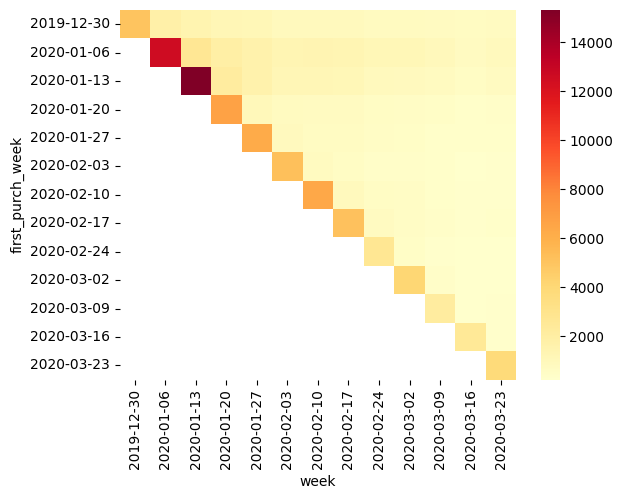

In [116]:
sns.heatmap(purchase_statistic, cmap='YlOrRd');

Первые три когорты демонстрируют в целом большую покупательскую активность во всём периоде своего существования.

Посмотрим на статистику покупок в процентах относительно 1-й недели каждой когорты.

In [137]:
purchases_pct = purchase_statistic

for week in purchases_pct.columns:
    purchases_pct.loc[week] = round(
        purchases_pct.loc[week]/purchases_pct.loc[week,week] * 100
        )
    
purchases_pct

week,2019-12-30,2020-01-06,2020-01-13,2020-01-20,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23
first_purch_week,,,,,,,,,,,,,
2019-12-30,100.0,35.0,29.0,24.0,23.0,18.0,19.0,18.0,16.0,16.0,15.0,14.0,15.0
2020-01-06,NaN,100.0,21.0,15.0,13.0,10.0,11.0,10.0,9.0,9.0,8.0,6.0,7.0
2020-01-13,NaN,NaN,100.0,14.0,11.0,8.0,8.0,7.0,6.0,6.0,5.0,4.0,5.0
2020-01-20,NaN,NaN,NaN,100.0,15.0,12.0,11.0,11.0,9.0,8.0,7.0,5.0,7.0
2020-01-27,NaN,NaN,NaN,NaN,100.0,14.0,11.0,11.0,9.0,8.0,6.0,6.0,7.0
2020-02-03,NaN,NaN,NaN,NaN,NaN,100.0,15.0,12.0,9.0,9.0,7.0,6.0,7.0
2020-02-10,NaN,NaN,NaN,NaN,NaN,NaN,100.0,15.0,10.0,9.0,6.0,5.0,5.0
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,14.0,11.0,8.0,6.0,7.0
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,18.0,12.0,9.0,11.0


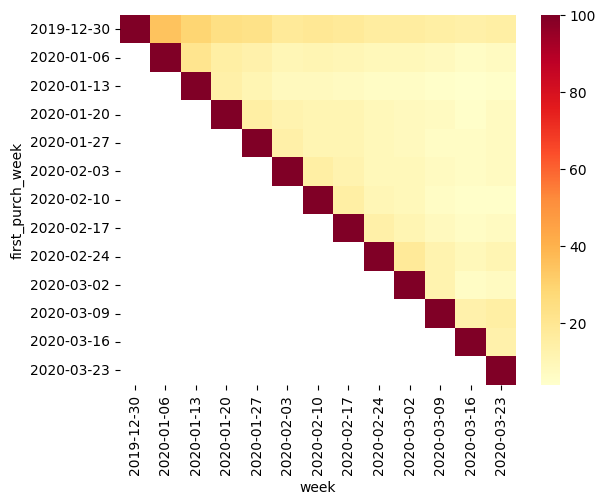

In [118]:
sns.heatmap(purchases_pct, cmap='YlOrRd');

Первая когорта от 30.12.2019 демонстрирует лучшие показатели по сравнению с первой неделей, \
когорта от 06.01.2020 показывает себя уже несколько хуже, \
в последующих когортах мы видим уже более низкие показатели покупательской активности, \
если сравнивать их с первой неделей.


### Сравним медианный чек на второй неделе с момента первой покупки для всех каналов привлечения. 

Создадим отдельный датафрейм с нужными столбцами и добавим отдельный столбец second_week,\
где значение 1 соответствует покупке, совершенной на второй неделе после первой покупки.

In [138]:
week_2_df = df[['device_id','date','week','event',
                'purchase_sum','utm_source','first_purch_week']]
week_2_df = week_2_df[week_2_df.event=='purchase']
week_2_df['first_purchase'] = week_2_df.device_id.apply(lambda x: first_purchases[x])
week_2_df['week'] = (pd.to_datetime(week_2_df.week)).dt.week
week_2_df['first_purch_week'] = (pd.to_datetime(week_2_df.first_purch_week)).dt.week
week_2_df['second_week'] = np.where(week_2_df.week - week_2_df.first_purch_week == 1, 1, 0)


C:\Users\79313\AppData\Local\Temp\ipykernel_9804\2602840159.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.

C:\Users\79313\AppData\Local\Temp\ipykernel_9804\2602840159.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



Вычислим медианный чек 2-й недели после первой покупки для разных каналов привлечения.

In [139]:
channels_med_bill = (week_2_df[week_2_df.second_week==1]
                     .groupby('utm_source')['purchase_sum']
                     .median().sort_values(ascending=False))
channels_med_bill

utm_source
instagram_ads    414.00
-                400.50
vk_ads           398.00
facebook_ads     396.00
yandex-direct    390.50
google_ads       385.00
referal          376.25
Name: purchase_sum, dtype: float64

Очевидно, что лидирует Инстаграм.

## Общие выводы
1) Если рассматривать динамику событий по дням, наблюдается **тенденция к снижению активности пользователей**.

2) Большую активность проявляют пользователи, уже установившие приложение  (по сравнению с теми, кто установил приложение в этот же день).

3) Лидером по **количеству установок** приложения оказалась группа пользователей, пришедших через **Яндекс**. Эта же группа демонстрирует самые высокий показатель первых открытий приложения.

4) Для **зарегистрированных** пользователей самым **проблематичным** этапом оказыватся этап **покупки**. Если конверсия на предыдущих шагах составляла более 90%, на этапе покупки конверсия равна **72%**. Возможно, имеет смысл проработать систему скидок и заинтересовывать пользователей специальными предложениями на этапе перехода в корзину (скидка на второй товар, скидка на следующую покупку, подарок при покупке, скидки в определённые часы, скидки активным пользователям). \
**Незарегистрированные** пользователи часто уходят на шаге **регистрации** (конверсия на этом шаге – **62%**), желательно максимально упростить этот шаг, который является обязательным для совершения покупки.

5) **Лучшие** показатели конверсии в первую покупку у пользователей, пришедших через **реферальную программу**, худшие – у пришедших через Яндекс. 

6) Самые **высокие** показатели **ROMI** у **ВК и реферальной программы**. Самые низкие – у Гугла. С точки зрения ROMI предпочтение следует отдать реферальной программе, ВК и Инстаграму. 

7) Когортный анализ и по неделе первого посещения, и по неделе первой покупки демонстрирует большую активность первых трёх когорт, самых ранних. \
Самые старые пользователи чаще пользуются приложением, покупают и приносят больше выручки. 

Необходимо детальнее исследовать причины снижения активности пользователей, сделать проще форму регистрации и продумать способы мотивирования клиентов к покупке. С точки зрения каналов имеет смысл инвестировать в ВК и Инстаграм. Отдельно следует уделить внимание рекламе на Яндексе – несколько видоизменить её и отследить, повысится ли при этом ROMI.